In [2]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K

from sificc_lib import AI, utils, Event, Simulation, root_files, DataModel

%matplotlib inline

In [4]:
model_name = 'model-2b-lvfz2'
shuffle_clusters = True

data = DataModel('data-mtx-enough-top-6.npz', 
                 batch_size = 64, validation_percent = .05, test_percent = .1)
data.append_dim = True

ai = AI(data, model_name)

np.random.seed(888)
ai.data.shuffle(only_train=False)

if shuffle_clusters:
    ai.data.shuffle_training_clusters()

In [5]:
ai.create_model(conv_layers=[128, 64], classifier_layers=[32], type_layers=[8], 
                pos_layers=[64,32], energy_layers=[32, 16], base_l2=.00003, limbs_l2=.00003)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 54, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 6, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 6, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 384)          0           conv_2[0][0]                     
______________________________________________________________________________________________

In [6]:
ai.compile_model(learning_rate=0.0003)

def lr_scheduler(epoch):
    if epoch < 100:
        return .0003
    elif epoch < 200:
        return .0001
    elif epoch < 280:
        return .00003
    elif epoch < 360:
        return .00001
    else:
        return .000003
        
l_callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler),
]

In [7]:
%%time
ai.train(epochs=400, shuffle=True, shuffle_clusters=shuffle_clusters, verbose=0, callbacks = l_callbacks)
ai.model.evaluate(ai.data.train_x, ai.data.train_y, verbose=1)
print()

17443/17443 [==============================] - 74s 4ms/step - loss: 3.1095 - e_cluster_loss: 0.0336 - p_cluster_loss: 0.0858 - type_loss: 0.3123 - pos_x_loss: 4.1748e-04 - pos_y_loss: 0.0388 - pos_z_loss: 7.0083e-04 - energy_loss: 0.4206 - e_cluster__cluster_accuracy: 0.9527 - p_cluster__cluster_accuracy: 0.8793 - type__type_accuracy: 0.8665 - type__type_tp_rate: 0.7796

CPU times: user 3d 23h 11min 35s, sys: 15h 6min 41s, total: 4d 14h 18min 16s
Wall time: 3d 16h 35min 11s


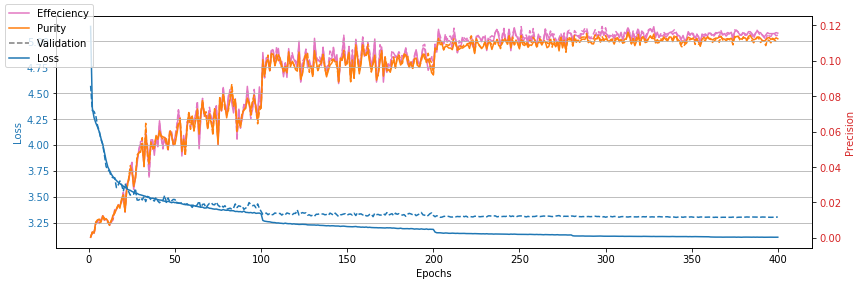

In [8]:
ai.plot_training_loss(smooth=False)

In [9]:
ai.evaluate()

AI model
  Loss:        3.31250
    -Type:         0.31375 *  0.05 = 0.01569
    -Pos X:        0.00040 * 12.00 = 0.00484
    -Pos Y:        0.03897 *  2.00 = 0.07795
    -Pos Z:        0.00067 *  8.00 = 0.00536
    -Energy:       0.44960 *  7.00 = 3.14719
    -Cls e:        0.03467 *  0.15 = 0.00520
    -Cls p:        0.08545 *  0.10 = 0.00855
  Accuracy:    0.86538
    -TP rate:      0.77992
    -Cls e rate:   0.95157
    -Cls p rate:   0.88304
  Efficiency:  0.11159
  Purity:      0.10885
  Euc mean:   11.87581
  Euc std:    30.24011

Reco
  Accuracy:    0.64592
    -TP rate:      0.74924
  Efficiency:  0.10264
  Purity:      0.05959
  Euc mean:   20.44427
  Euc std:    48.46802


In [10]:
ai.save(file_name=model_name)